In [1]:
# Install OpenPifPaf
!pip install openpifpaf

# Install necessary packages
!pip install matplotlib torch torchvision opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.3/202.3 kB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl.metadata (24 kB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.whl (887.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.2/24.2 MB 10.7 MB/s eta 0:00:00
Using cached nvidia_cublas_cu11-11.10.3.66-py3-n

In [6]:
import openpifpaf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from openpifpaf import decoder, network
from google.colab import files

Downloading: "http://github.com/openpifpaf/torchhub/releases/download/v0.13/resnet50-210830-150728-cocokp-slurm728641-edge513-o10s-ecd30da4.pkl" to /root/.cache/torch/hub/checkpoints/resnet50-210830-150728-cocokp-slurm728641-edge513-o10s-ecd30da4.pkl


  0%|          | 0.00/97.4M [00:00<?, ?B/s]

<ipython-input-1-0513e728459b>:11: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))


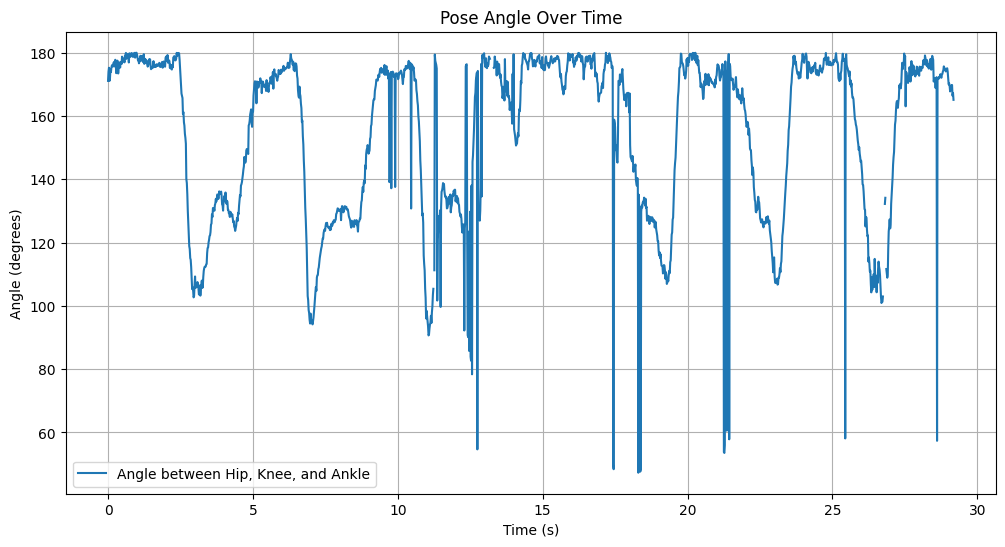

In [ ]:
def calculate_angle(a, b, c):
    ab = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def process_video_openpifpaf(video_path):

    predictor = openpifpaf.Predictor(checkpoint="resnet50")

    cap = cv2.VideoCapture(video_path)
    angles = []
    frame_times = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        predictions, _, _ = predictor.numpy_image(rgb_frame)

        if predictions:
            keypoints = predictions[0].data[:, :2]

            left_hip = keypoints[11]
            left_knee = keypoints[13]
            left_ankle = keypoints[15]


            angle = calculate_angle(left_hip, left_knee, left_ankle)
            angles.append(angle)
            frame_times.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)

    cap.release()
    return frame_times, angles

def plot_angles(frame_times, angles):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_times, angles, label='Angle between Hip, Knee, and Ankle')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Pose Angle Over Time')
    plt.legend()
    plt.grid()
    plt.show()

# Run the process on a sample video
video_path = '/content/video.mp4'  # Replace this with your video path
frame_times, angles = process_video_openpifpaf(video_path)
plot_angles(frame_times, angles)


<ipython-input-7-5bfb63ebde67>:4: RuntimeWarning: invalid value encountered in scalar divide
  cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

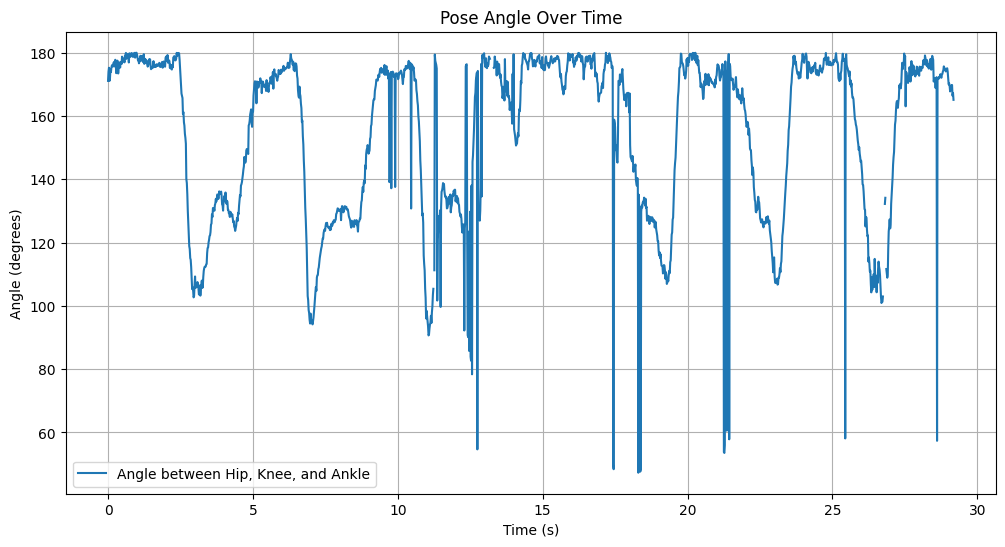

In [7]:
def calculate_angle(a, b, c):
    ab = np.array(a) - np.array(b)
    bc = np.array(c) - np.array(b)
    cos_angle = np.dot(ab, bc) / (np.linalg.norm(ab) * np.linalg.norm(bc))
    angle = np.degrees(np.arccos(np.clip(cos_angle, -1.0, 1.0)))
    return angle

def draw_keypoints(frame, keypoints):
    for keypoint in keypoints:
        x, y = int(keypoint[0]), int(keypoint[1])
        cv2.circle(frame, (x, y), 6, (0, 255, 0), -1)

def draw_connections(frame, keypoints):
    connections = [(11, 13), (13, 15), (11, 12), (12, 14), (14, 16)]  # Example: Hips, Knees, Ankles
    for connection in connections:
        start_idx, end_idx = connection
        start_point = tuple(keypoints[start_idx].astype(int))
        end_point = tuple(keypoints[end_idx].astype(int))
        cv2.line(frame, start_point, end_point, (0, 0, 255), 3)

def process_video_openpifpaf(video_path):

    predictor = openpifpaf.Predictor(checkpoint="resnet50")

    cap = cv2.VideoCapture(video_path)
    angles = []
    frame_times = []

    # Video output setup
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter('output_openpifpaf.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        predictions, _, _ = predictor.numpy_image(rgb_frame)

        if predictions:
            keypoints = predictions[0].data[:, :2]

            # Calculate angle for left leg
            left_hip = keypoints[11]
            left_knee = keypoints[13]
            left_ankle = keypoints[15]
            angle = calculate_angle(left_hip, left_knee, left_ankle)

            angles.append(angle)
            frame_times.append(cap.get(cv2.CAP_PROP_POS_MSEC) / 1000.0)

            # Draw keypoints and connections
            draw_keypoints(frame, keypoints)
            draw_connections(frame, keypoints)

        out.write(frame)

    cap.release()
    out.release()

    # Download the video
    files.download('output_openpifpaf.mp4')

    return frame_times, angles

def plot_angles(frame_times, angles):
    plt.figure(figsize=(12, 6))
    plt.plot(frame_times, angles, label='Angle between Hip, Knee, and Ankle')
    plt.xlabel('Time (s)')
    plt.ylabel('Angle (degrees)')
    plt.title('Pose Angle Over Time')
    plt.legend()
    plt.grid()
    plt.show()

# Run the process on a sample video
video_path = '/content/video.mp4'  # Replace this with your video path
frame_times, angles = process_video_openpifpaf(video_path)
plot_angles(frame_times, angles)
